In [2]:
import torch
print("Torch Version: {}".format(torch.__version__))

Torch Version: 1.8.1


In [3]:
import numpy as np
print("Numpy Version: {}".format(np.__version__))

Numpy Version: 1.19.2


In [4]:
import matplotlib
print("Matplotlib Version: {}".format(matplotlib.__version__))

Matplotlib Version: 3.3.2


In [5]:
import torchvision 
print("Torchvision Version: {}".format(torchvision.__version__))

Torchvision Version: 0.9.1


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
batch_size = 20

valid_size = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.5), (0.5,))
    ])

train_data = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)

test_data = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

test_loader = DataLoader(test_data, batch_size=batch_size)

classes = ['T-shirt/top',
            'Trouser',
            'Pullover',
            'Dress',
            'Coat',
            'Sandal',
            'Shirt',
            'Sneaker',
            'Bag',
            'Ankle Boot']

In [8]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = F.log_softmax(self.fc5(x), dim=1)

    return x

In [9]:
model = Net()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [42]:
epochs = 50
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

for e in range(epochs):
    train_loss, valid_loss = 0.0, 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    model.eval
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)

    
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'fashion_mnist_ann.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.358861 	Validation Loss: 0.769927
Validation loss decreased (inf --> 0.769927).  Saving model ...
Epoch: 2 	Training Loss: 0.663367 	Validation Loss: 0.583180
Validation loss decreased (0.769927 --> 0.583180).  Saving model ...
Epoch: 3 	Training Loss: 0.548222 	Validation Loss: 0.521153
Validation loss decreased (0.583180 --> 0.521153).  Saving model ...
Epoch: 4 	Training Loss: 0.486952 	Validation Loss: 0.484718
Validation loss decreased (0.521153 --> 0.484718).  Saving model ...
Epoch: 5 	Training Loss: 0.452480 	Validation Loss: 0.442287
Validation loss decreased (0.484718 --> 0.442287).  Saving model ...
Epoch: 6 	Training Loss: 0.425699 	Validation Loss: 0.414073
Validation loss decreased (0.442287 --> 0.414073).  Saving model ...
Epoch: 7 	Training Loss: 0.404787 	Validation Loss: 0.406415
Validation loss decreased (0.414073 --> 0.406415).  Saving model ...
Epoch: 8 	Training Loss: 0.388965 	Validation Loss: 0.382574
Validation loss decreased (0.40641

In [11]:
model.load_state_dict(torch.load("fashion_mnist_ann.pt"))

<All keys matched successfully>

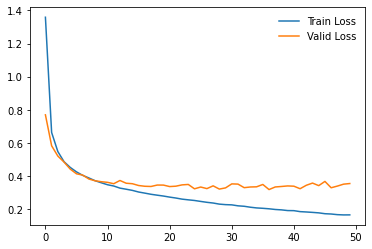

In [46]:
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.legend(frameon=False)
plt.show()

In [49]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.334308

Test Accuracy of     0: 88% (883/1000)
Test Accuracy of     1: 96% (963/1000)
Test Accuracy of     2: 83% (830/1000)
Test Accuracy of     3: 88% (886/1000)
Test Accuracy of     4: 85% (855/1000)
Test Accuracy of     5: 96% (968/1000)
Test Accuracy of     6: 63% (637/1000)
Test Accuracy of     7: 95% (952/1000)
Test Accuracy of     8: 97% (975/1000)
Test Accuracy of     9: 95% (958/1000)

Test Accuracy (Overall): 89% (8907/10000)


<ipython-input-12-f1f3f6e58f11>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


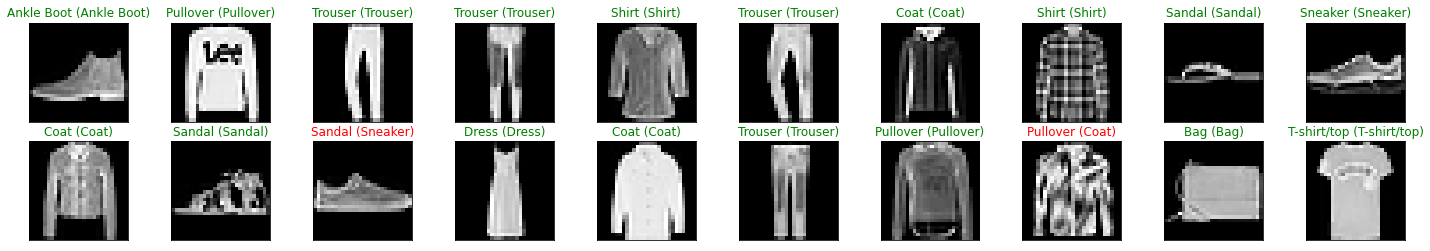

In [12]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)
images = images.cpu().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[(preds[idx].item())], classes[(labels[idx].item())]),
                 color=("green" if preds[idx]==labels[idx] else "red"))